In [29]:
import requests, re, math
from datetime import datetime, timedelta
import numpy as np, pandas as pd
import bs4
from bs4 import BeautifulSoup
from collections import namedtuple, defaultdict, deque
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt, rcParams
from matplotlib import cycler

In [30]:
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
    axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
rcParams["font.size"] = 15
rcParams['legend.loc'] = 'center left'
rcParams['legend.fancybox'] = True

In [31]:
url = "https://en.wikipedia.org/wiki/Timeline_of_Apple_Inc._products"
response = requests.get(url)

In [32]:
soup = BeautifulSoup(response.text, 'html.parser')

In [33]:
dat= soup.findAll('td')

In [34]:
r_year = re.compile("\d\d\d\d")
r_month_day = re.compile("((January)|(February)|(March)|(April)|(May)|(June)|(July)|(August)|(September)|(October)|(November)|December)\s\d+")
r_discontinued = re.compile("(\w+\s\d+,\s\d+)|(\d\d\d\d)|(((January)|(February)|(March)|(April)|(May)|(June)|(July)|(August)|(September)|(October)|(November)|December)\s\d+)|(current)")
# r_product = re.compile(r'(?<=\">)[a-zA-Z0-9 &;:\",.()$*\\]+?(?=\</a>)')   # '(?<=\">)[a-zA-Z0-9 &;:\",.()$*\\\\]+?(?=\</a>)'
# Product = namedtuple('Product', ['name', 'family', 'release_date', 'discontinued_date'])

In [35]:
# for row in dat[:100]:
#     text = row.text
#     print(f'{text = }')

In [36]:
head = list()
header = soup.findAll('table')[0].find('tr')
for item in header:
    if type(item) == bs4.element.Tag:
        head.append(item.text.strip())
head

['Year', 'Release Date', 'Model', 'Family', 'Discontinued']

In [37]:
num_table = 39
months = {
    'January':1,
    'February':2,
    'March':3,
    'April':4,
    'May':5,
    'June':6,
    'July':7,
    'August':8,
    'September':9,
    'October':10,
    'November':11,
    'December':12}

In [38]:
start_dat = soup.findAll('table')
dat = list()
for table in start_dat[:num_table]:
    table_dat = table.findAll('tr')[1:]
    for element in table_dat:
        sub = deque()
        for sub_element in element:
            if type(sub_element) == bs4.element.Tag:
                sub.append(sub_element.text.strip())
        while len(sub) < len(head):
            if r_year.match(sub[0]) == None:
                sub.appendleft(dat[-1][0])
                continue
            if sub[-1] != '' and r_discontinued.match(sub[-1]) == None:
                sub.append(dat[-1][-1])
                continue
            if r_month_day.match(sub[1]) == None:
                sub.insert(1, dat[-1][1])
                continue
            sub.insert(3, dat[-1][3])
        dat.append(sub)

In [39]:
for item in dat:
    year = item.popleft()
    rest = item.popleft()
    try:
        month, day = rest.split(' ')
    except:
        month = rest
        day = 15
    item.appendleft(datetime(int(year), months[month], int(day)))

In [40]:
header = ['Release Date']
header.extend(head[2:])
data = pd.DataFrame(data=dat, columns=header)
data.head()

,Release Date,Model,Family,Discontinued
0,1976-04-11,Apple I,Apple I,"September 1, 1977"
1,1977-04-01,Apple II,Apple II,"June 1, 1979"
2,1978-06-01,Disk II,Drives,"May 1, 1984"
3,1979-06-01,Apple II Plus,Apple II series,"December 1, 1982"
4,1979-06-01,Apple II EuroPlus,Apple II series,"December 1, 1982"


In [41]:
data['Family'].unique()

array(['Apple I', 'Apple II', 'Drives', 'Apple II series', 'Printers',
       'Apple III', 'Modems', 'Displays', '68000', 'ImageWriter',
       'Compact', 'Apple Mouse', 'Networking', 'Mac II', 'Scanner',
       'Portable', 'LaserWriter', 'Macintosh LC', 'StyleWriter',
       'Printer', 'Quadra', 'PowerBook', 'Performa', 'Display',
       'PowerBook Duo', 'Centris', 'Workgroup Server', 'PowerCD',
       'Centris / Quadra', 'Newton', 'Performa 550', 'LC', 'QuickTake',
       'Power Macintosh', 'PowerBook 500', 'Pippin',
       'Power Macintosh / LC', 'Network Server', 'PowerBook G3',
       'Macintosh Server', 'iMac', 'iBook', 'AirPort', 'Macintosh',
       'PowerBook G4', 'iPod Classic', 'eMac', 'Xserve', 'iPod Mini',
       'iPod accessories', 'AirPort Express', 'Mac Mini', 'iPod Shuffle',
       'iPod Nano', 'MacBook Pro', 'MacBook', 'Mac Pro', 'Apple TV',
       'iPhone', 'iPhone Accessories', 'Apple Keyboard', 'iPod Touch',
       'MacBook Air', 'AirPort, drives', 'iPad', 'Trackpad

In [42]:
mac_mini = data[data['Family'] == 'Mac Mini'].copy()
macbook_pro = data[data['Family'] == 'MacBook Pro'].copy()
macbook_air = data[data['Family'] == 'MacBook Air'].copy()
mac_pro = data[data['Family'] == 'Mac Pro'].copy()

In [43]:
def add_delay(df):
    df[['Release Date Shifted']] = df[['Release Date']].shift(periods=1)   
    df[['Delay']] = df['Release Date'] - df['Release Date Shifted']
    df[['Delay_sec']] = df['Delay'].dt.total_seconds()
    df[['Release Date (ordinal)']] = df['Release Date'].apply(lambda x: x.toordinal())
    df.drop('Release Date Shifted', axis=1)
    return df

def remove_outliers(df):
    df = df.mask(df.eq(0)).dropna(how='all', axis=1)
    Q1 = df['Delay_sec'].quantile(.25)
    Q3 = df['Delay_sec'].quantile(.75)
    IQR = Q3 - Q1
    
    return df.query('(@Q1 - 1.5 * @IQR) <= Delay_sec <= (@Q3 + 1.5 * @IQR)')

def add_index(df):
    df = df.reset_index()
    df.pop('index')
    df = df.reset_index()
    return df

In [44]:
def fit_releases(df):
    lr1, lr2 = LinearRegression(), LinearRegression()
    lr1.fit(df[['index']], df[['Delay_sec']])
    lr2.fit(df[['index']], df[['Release Date (ordinal)']])
    return lr1, lr2

def plot_releases(df, delay_lr, release_lr):
    fig, axs = plt.subplots(figsize=(16,8), ncols=2)
    ax1, ax2 = axs
    ax1.set_title('Linear regression on time delta between releases')
    df.plot('index', 'Delay_sec', ax=ax1, ylabel='Seconds between launches', xlabel='Release number')
    ax1.plot(ax1.get_xlim(), [delay_lr.coef_[0][0]*ax1.get_xlim()[0] + delay_lr.intercept_[0], delay_lr.coef_[0][0]*ax1.get_xlim()[1] + delay_lr.intercept_[0]], color='royalblue')

    ax2.set_title('Linear regression on ordinal release date')
    df.plot('index', 'Release Date (ordinal)', ax=ax2, ylabel='Oridnal release date', xlabel='Release number')
    ax2.plot(ax2.get_xlim(), [release_lr.coef_[0][0]*ax2.get_xlim()[0] + release_lr.intercept_[0], release_lr.coef_[0][0]*ax2.get_xlim()[1] + release_lr.intercept_[0]], color='royalblue')
    plt.show()

def predict_next_release(df, df_clean, delay_lr, release_lr):
    num_points = len(df_clean)
    delay_prediction = df['Release Date'][len(df)-1] + timedelta(seconds=delay_lr.predict(np.arange(num_points-1,num_points).reshape(-1,1))[0][0])
    release_prediction = datetime.fromordinal(int(release_lr.predict(np.arange(num_points-1,num_points).reshape(-1,1))[0][0]))
    return f'The next product release is {delay_prediction} using a linear regression on the time delta between releases and the last known release and {release_prediction} using the linear regression on ordinal release dates'

### MacBook Air regression

In [54]:
macbook_air = macbook_air.pipe(add_delay).pipe(add_index)
macbook_air_clean = macbook_air.pipe(remove_outliers)
macbook_air_clean.head()

,index,Release Date,Model,Family,Discontinued,Release Date Shifted,Delay,Delay_sec,Release Date (ordinal)
1,1.0,2008-10-14,MacBook Air (Late 2008),MacBook Air,"June 8, 2009",2008-01-15,273 days,23587200.0,733329
2,2.0,2009-06-08,MacBook Air (Mid 2009),MacBook Air,"October 20, 2010",2008-10-14,237 days,20476800.0,733566
3,3.0,2010-10-20,MacBook Air (Late 2010),MacBook Air,"July 20, 2011",2009-06-08,499 days,43113600.0,734065
4,4.0,2011-07-20,MacBook Air (Mid 2011),MacBook Air,"June 11, 2012",2010-10-20,273 days,23587200.0,734338
5,5.0,2012-06-11,MacBook Air (Mid 2012),MacBook Air,"June 10, 2013",2011-07-20,327 days,28252800.0,734665


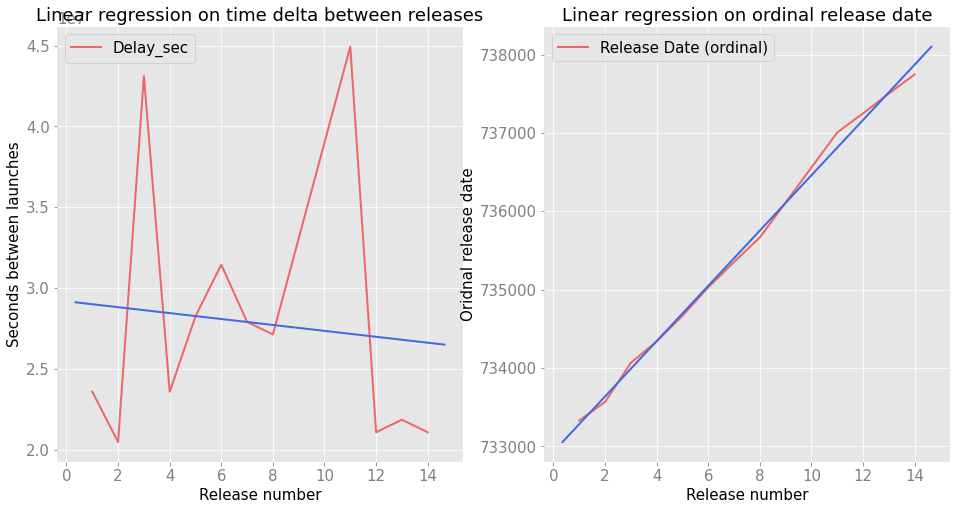

'The next product release is 2021-09-27 11:04:52.189893 using a linear regression on the time delta between releases and the last known release and 2018-04-28 00:00:00 using the linear regression on ordinal release dates'

In [56]:
lr1, lr2 = fit_releases(macbook_air_clean)
plot_releases(macbook_air_clean, lr1, lr2)
predict_next_release(macbook_air, macbook_air_clean, lr1, lr2)

### Mac Mini regression

In [19]:
mac_mini = mac_mini.pipe(add_delay).pipe(add_index)
mac_mini = mac_mini.pipe(remove_outliers)
mac_mini_clean.head()

,index,Release Date,Model,Family,Discontinued,Release Date Shifted,Delay,Delay_sec,Release Date (ordinal)
0,0,2006-02-28,Mac Mini Core Solo,Mac Mini,"September 6, 2006",2005-01-11,413 days,35683200.0,732370
1,1,2007-08-07,Mac Mini (Mid 2007),Mac Mini,"March 3, 2009",2006-02-28,525 days,45360000.0,732895
2,2,2009-03-03,Mac Mini (Early 2009),Mac Mini,"October 20, 2009",2007-08-07,574 days,49593600.0,733469
3,3,2009-10-20,Mac Mini (Late 2009),Mac Mini,"June 15, 2010",2009-03-03,231 days,19958400.0,733700
4,4,2010-06-15,Mac Mini (Mid 2010),Mac Mini,"July 20, 2011",2009-10-20,238 days,20563200.0,733938


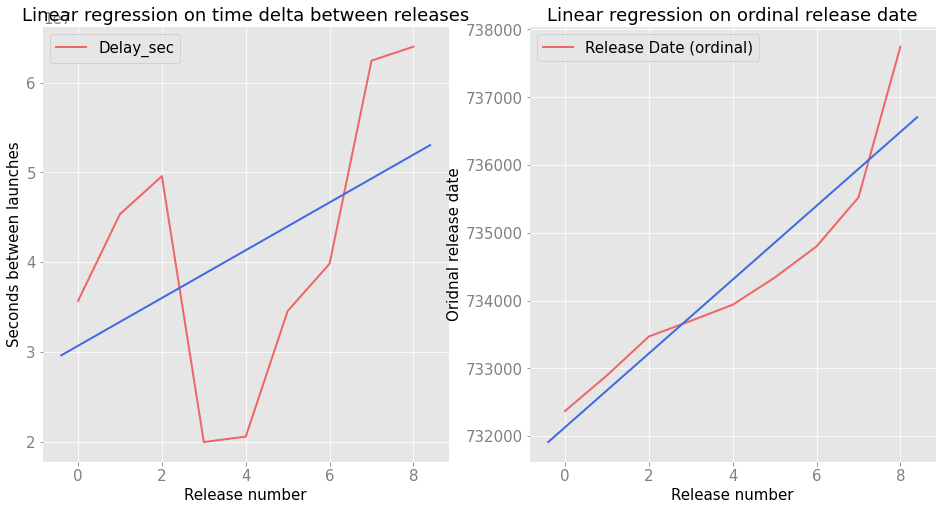

'The next product release is 2022-07-11 17:04:00 using a linear regression on the time delta between releases and the last known release and 2017-06-07 00:00:00 using the linear regression on ordinal release dates'

In [21]:
lr1, lr2 = fit_releases(mac_mini_clean)
plot_releases(mac_mini_clean, lr1, lr2)
predict_next_release(mac_mini, mac_mini_clean, lr1, lr2)

### MacBook Pro regression

In [57]:
macbook_pro = macbook_pro.pipe(add_delay).pipe(add_index)
macbook_pro_clean = macbook_pro.pipe(remove_outliers)
macbook_pro_clean.head()

,index,Release Date,Model,Family,Discontinued,Release Date Shifted,Delay,Delay_sec,Release Date (ordinal)
1,1.0,2006-04-24,"MacBook Pro (17"")",MacBook Pro,"February 26, 2008",2006-02-14,69 days,5961600.0,732425
4,4.0,2008-10-14,"MacBook Pro (Late 2008) (15"")",MacBook Pro,"June 8, 2009",2008-02-26,231 days,19958400.0,733329
5,5.0,2009-01-06,"MacBook Pro (Early 2009) (17"")",MacBook Pro,"June 8, 2009",2008-10-14,84 days,7257600.0,733413
6,6.0,2009-06-08,MacBook Pro (Mid 2009),MacBook Pro,"April 13, 2010",2009-01-06,153 days,13219200.0,733566
7,7.0,2010-04-13,MacBook Pro (Mid 2010),MacBook Pro,"February 24, 2011",2009-06-08,309 days,26697600.0,733875


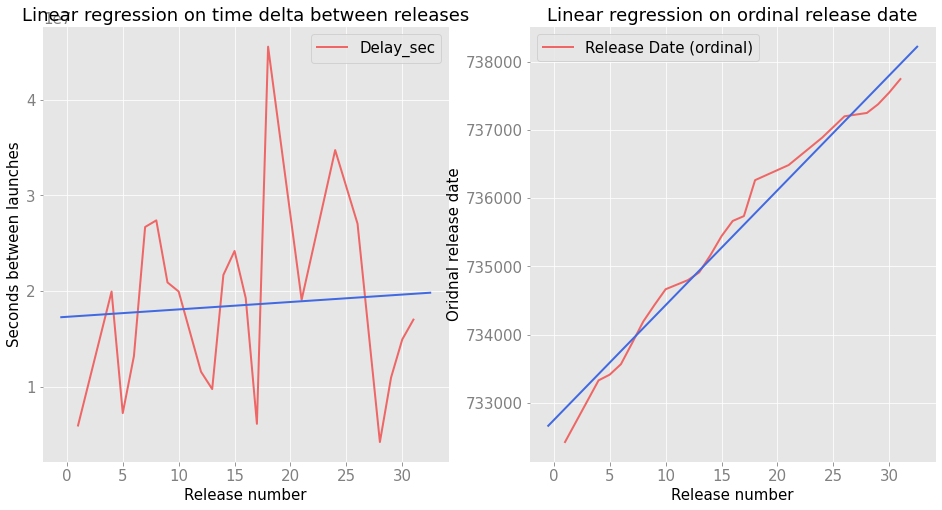

'The next product release is 2021-06-24 05:17:15.788180 using a linear regression on the time delta between releases and the last known release and 2016-11-15 00:00:00 using the linear regression on ordinal release dates'

In [64]:
lr1, lr2 = fit_releases(macbook_pro_clean)
plot_releases(macbook_pro_clean, lr1, lr2) 
predict_next_release(macbook_pro, macbook_pro_clean, lr1, lr2)

### Mac Pro regression

In [25]:
mac_pro

,Release Date,Model,Family,Discontinued
361,2006-08-07,Mac Pro,Mac Pro,"January 8, 2008"
379,2008-01-08,Mac Pro (Early 2008),Mac Pro,"March 3, 2009"
406,2009-03-03,Mac Pro (Early 2009),Mac Pro,"August 9, 2010"
439,2010-08-09,Mac Pro (Mid 2010),Mac Pro,"June 11, 2012"
462,2012-06-11,Mac Pro (Mid 2012),Mac Pro,"December 19, 2013"
502,2013-12-19,Mac Pro (Late 2013),Mac Pro,"December 10, 2019"
628,2019-12-10,Mac Pro (Late 2019),Mac Pro,current


In [67]:
mac_pro = mac_pro.pipe(add_delay).pipe(add_index)
mac_pro_clean = mac_pro.pipe(remove_outliers)
macbook_pro_clean.head()

,index,Release Date,Model,Family,Discontinued,Release Date Shifted,Delay,Delay_sec,Release Date (ordinal)
1,1.0,2006-04-24,"MacBook Pro (17"")",MacBook Pro,"February 26, 2008",2006-02-14,69 days,5961600.0,732425
4,4.0,2008-10-14,"MacBook Pro (Late 2008) (15"")",MacBook Pro,"June 8, 2009",2008-02-26,231 days,19958400.0,733329
5,5.0,2009-01-06,"MacBook Pro (Early 2009) (17"")",MacBook Pro,"June 8, 2009",2008-10-14,84 days,7257600.0,733413
6,6.0,2009-06-08,MacBook Pro (Mid 2009),MacBook Pro,"April 13, 2010",2009-01-06,153 days,13219200.0,733566
7,7.0,2010-04-13,MacBook Pro (Mid 2010),MacBook Pro,"February 24, 2011",2009-06-08,309 days,26697600.0,733875


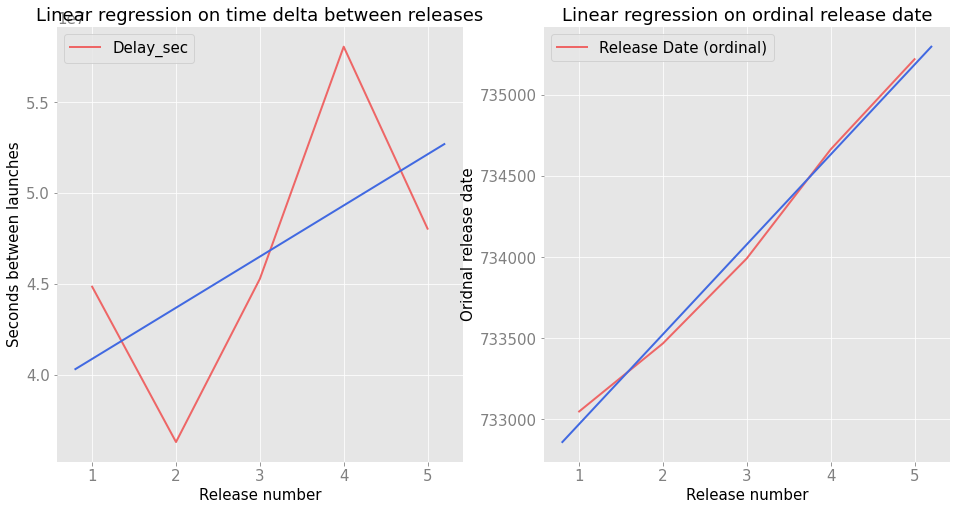

'The next product release is 2021-07-02 19:12:00 using a linear regression on the time delta between releases and the last known release and 2012-05-10 00:00:00 using the linear regression on ordinal release dates'

In [68]:
lr1, lr2 = fit_releases(mac_pro_clean)
plot_releases(mac_pro_clean, lr1, lr2) 
predict_next_release(mac_pro, mac_pro_clean, lr1, lr2)

In [ ]:
# TODO: Use the last known product release to add timedelta to even if it is an outlier - DONE
# TODO: 
#
#
